In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ice-ts-dataset/ice_cream.csv


In [53]:
df = pd.read_csv(
    "/kaggle/input/ice-ts-dataset/ice_cream.csv", 
    index_col=0,  # Rend la première colonne comme index
    parse_dates=[0]  # Interprète la première colonne comme des dates
)
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [54]:
df.rename(columns={'IPN31152N' : 'Sales'}, inplace=True)
df

,Sales
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


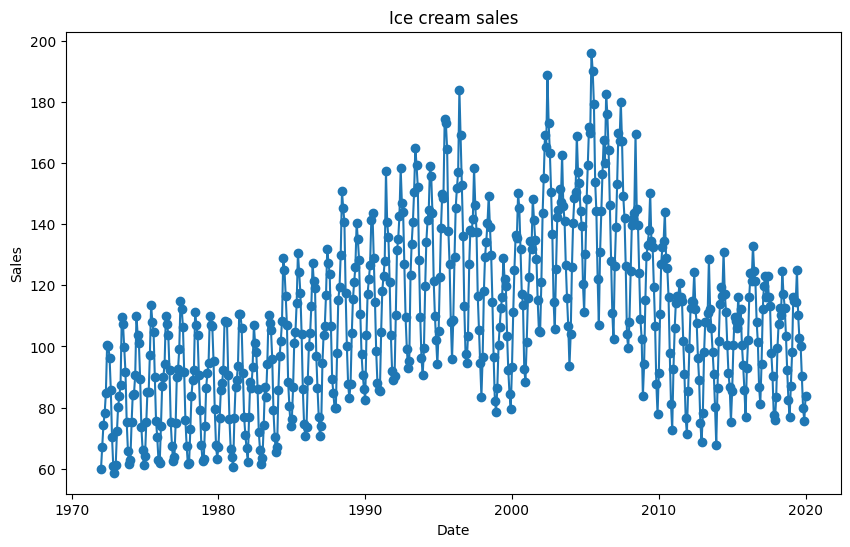

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Sales,marker='o',linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Ice cream sales')
plt.show()

In [56]:
df = df.asfreq(pd.infer_freq(df.index))
print(df.index.freq)

<MonthBegin>


In [57]:
start_data = pd.to_datetime('2010-01-01')
df1 = df[start_data:]
df1.tail()

,Sales
DATE,
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223
2019-12-01,75.7094
2020-01-01,83.6290


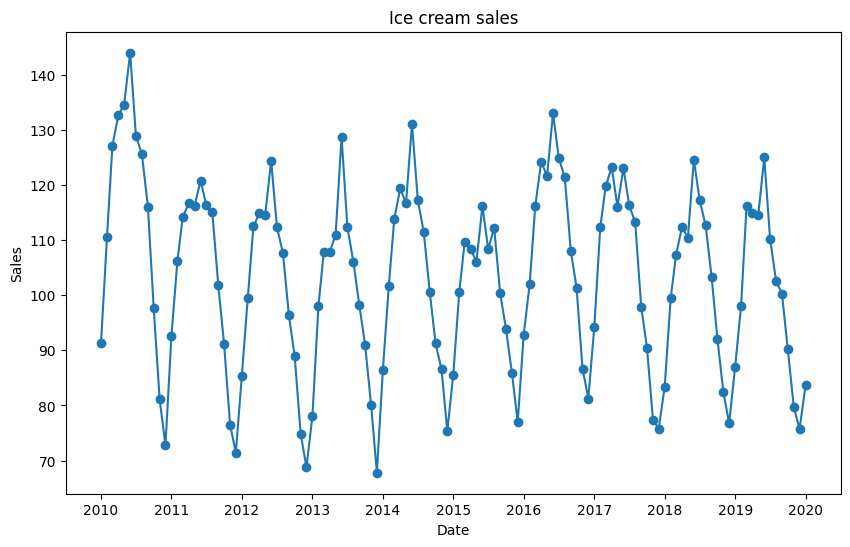

In [58]:
plt.figure(figsize=(10,6))
plt.plot(df1,marker='o',linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Ice cream sales')
plt.show()

### 1. Basic RNN Models to use for Time Series:
        1.1 Data Preparing:

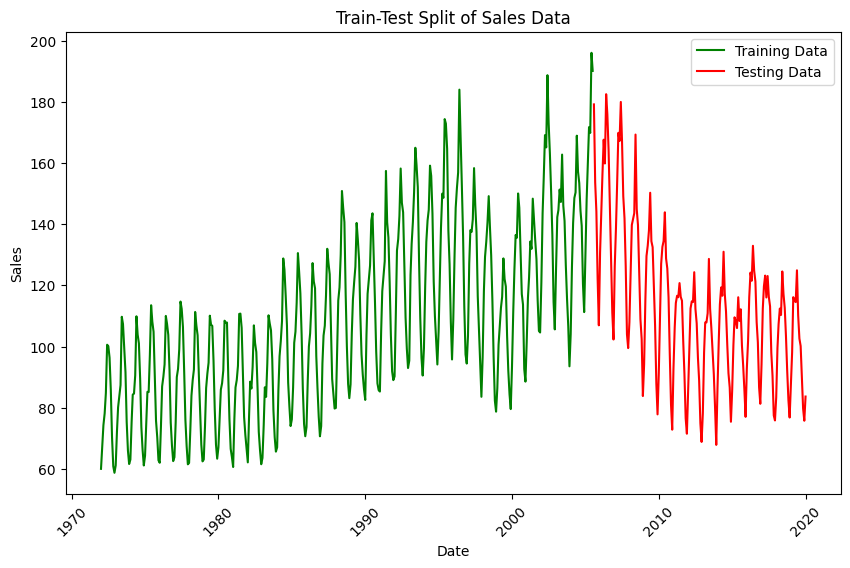

In [59]:
split_index = int(len(df) * 0.7)

# Create the plot for the entire dataset
plt.figure(figsize=(10, 6))

# Highlight the training set
plt.plot(df.index[:split_index], df["Sales"][:split_index], label="Training Data", color='green')

# Highlight the testing set
plt.plot(df.index[split_index:], df["Sales"][split_index:], label="Testing Data", color='red')

# Adding labels and title
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Train-Test Split of Sales Data")

# Add a legend
plt.legend()

# Show the plot
plt.xticks(rotation=45)
plt.show()

In [60]:
sequence_length = 24
vals = df["Sales"].values
X, y = [], []
for i in range(len(vals) - sequence_length):
    X.append(vals[i: i + sequence_length])
    y.append(vals[i + sequence_length])
X, y = np.array(X), np.array(y)
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

    1.2 Implementing a simple RNN model:

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the RNN model
model_RNN = Sequential([
    SimpleRNN(64, input_shape=(sequence_length, 1), activation='relu', return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Reduce learning rate on plateau callback
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Compile the model
model_RNN.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Display the model summary
model_RNN.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_15 (SimpleRNN)            │ (None, 24, 64)              │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_16 (SimpleRNN)            │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,361 (28.75 KB)

 Trainable params: 7,361 (28.75 KB)

 Non-trainable params: 0 (0.00 B)

# **SimpleRNN: Layer & Mathematical Formulation**
`SimpleRNN` is a fundamental recurrent neural network (RNN) layer in TensorFlow/Keras. It processes sequential data by maintaining a hidden state that updates at each time step.

---

## **1. `SimpleRNN` as a Layer**
- The `SimpleRNN` layer is a fully connected recurrent layer that processes sequences one step at a time.
- It **stores memory** using hidden states, allowing it to capture short-term dependencies.
- Unlike LSTM or GRU, `SimpleRNN` struggles with **long-term dependencies** due to vanishing gradients.

### **Key Parameters**
- `units`: Number of neurons in the RNN cell (determines hidden state size).
- `activation`: Default is `"tanh"`, which helps maintain stable gradients.
- `return_sequences`: If `True`, returns hidden states at each time step.
- `return_state`: If `True`, returns the final hidden state.
- `input_shape`: (sequence_length, number_of_features).

---

## **2. Mathematical Formulation**
![Online Image](https://www.researchgate.net/publication/366805579/figure/fig1/AS:11431281111343557@1672936373986/Structure-of-the-SimpleRNN-network.ppm)

At each time step t, `SimpleRNN` updates its hidden state $h_t$  as:

$$
\Large h_t = \tanh(W_h h_{t-1} + W_x x_t + b)
$$

where:
- $x_t$ = input at time step t .
- $h_t$ = hidden state at time  t.
- $W_h$ = weight matrix for the previous hidden state.
- $W_x$ = weight matrix for the input.
- $b$ = bias term.
- $tanh$ = non-linear activation function.

The output is often:

$$
\Large y_t = W_y h_t + b_y
$$

if connected to a Dense layer for predictions.

---

## **3. `SimpleRNN` vs Other RNN Layers**
| Feature        | SimpleRNN | LSTM | GRU |
|--------------|-----------|------|-----|
| Captures Long-Term Dependencies? | ❌ No (Vanishing Gradient) | ✅ Yes | ✅ Yes |
| Computationally Efficient? | ✅ Yes | ❌ No (More Parameters) | 🔄 Moderate |
| Internal Gates? | ❌ No | ✅ Yes (Forget, Input, Output) | ✅ Yes (Update, Reset) |

In [62]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Reshape to 2D (samples, features) before scaling
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Fit and transform
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to 3D for LSTM (samples, time_steps, features) (In general)
# In this case, we only have 1 feature. Hence, (samples, time_steps, 1) is equivalent to (samples, time_steps)
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

print(X_train.shape)  
print(y_train.shape)  

(403, 24)
(403,)


In [63]:
history = model_RNN.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=250, 
                    callbacks=[reduceLR])

Epoch 1/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - loss: 3213.7043 - val_loss: 560.0530 - learning_rate: 0.0100
Epoch 2/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1233.6294 - val_loss: 406.3806 - learning_rate: 0.0100
Epoch 3/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 842.1791 - val_loss: 172.0709 - learning_rate: 0.0100
Epoch 4/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 929.0747 - val_loss: 548.5231 - learning_rate: 0.0100
Epoch 5/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 812.9742 - val_loss: 128.8381 - learning_rate: 0.0100
Epoch 6/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 585.3513 - val_loss: 119.5243 - learning_rate: 0.0100
Epoch 7/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 581.2569 - val_loss: 244.9946 - learning_rate: 0.0100
Epoch 8/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 600.5308 - val_loss: 147.5296 - learning_rate: 0.0100
Epoch 9/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 561.8310 - val_loss: 101.

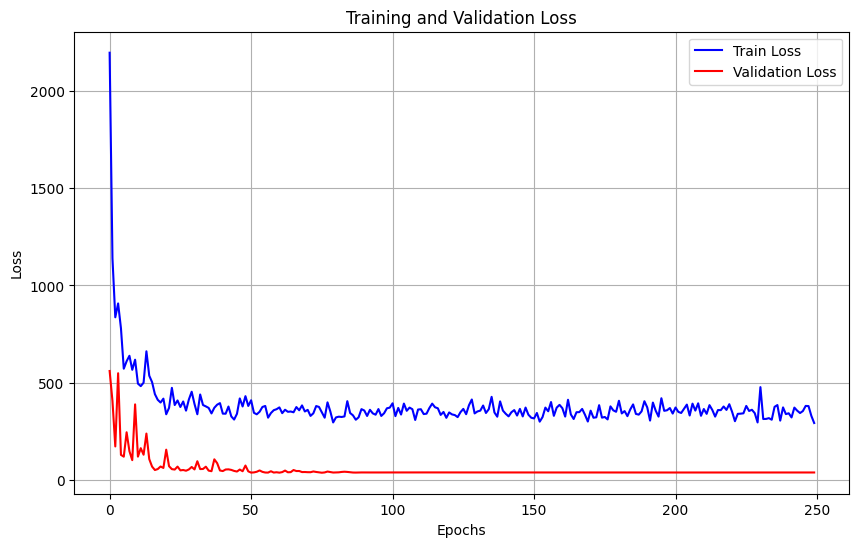

In [64]:
# Plot the loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


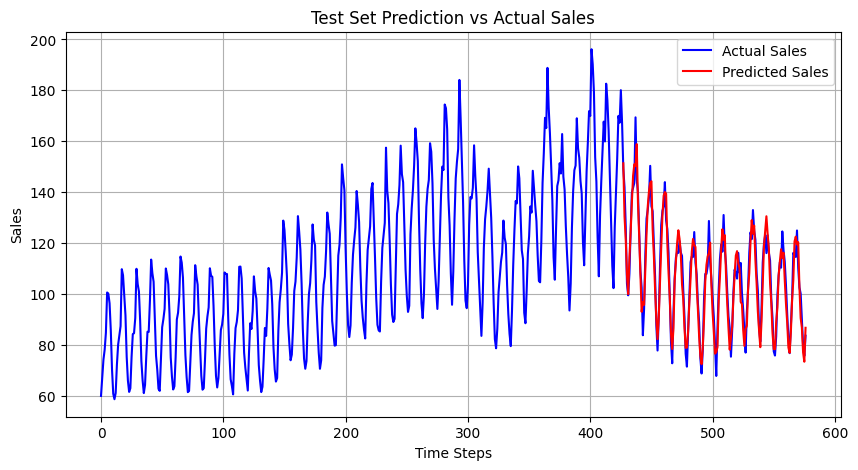

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape X_test to match the model input shape (batch_size, sequence_length, 1)
X_test_reshaped = np.array(X_test).reshape(-1, sequence_length, 1)

# Make predictions on the test set
y_pred = model_RNN.predict(X_test_reshaped)

# Convert predictions to a 1D array
y_pred = y_pred.flatten()

# Define time steps for the test set
time_steps_test = np.arange(split_index + sequence_length, len(vals))

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(vals, label="Actual Sales", color='blue')
plt.plot(time_steps_test, y_pred, label="Predicted Sales", color='red')
plt.legend()
plt.grid(True)
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.title("Test Set Prediction vs Actual Sales")
plt.show()

    1.3 Implementing an LSTM Model

In [79]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Reshape to 2D (samples, features) before scaling
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Fit and transform
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to 3D for LSTM (samples, time_steps, features) (In general)
# In this case, we only have 1 feature. Hence, (samples, time_steps, 1) is equivalent to (samples, time_steps)
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

print(X_train.shape)  
print(y_train.shape)  

(403, 24)
(403,)


In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_LSTM = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
    
    LSTM(64),
    Dense(64, activation='relu'),
    
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    
    Dropout(0.2),
    Dense(1)
])

# Reduce learning rate on plateau callback
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

# Compile the model
model_LSTM.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Display the model summary
model_LSTM.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 24, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,193 (219.50 KB)

 Trainable params: 56,193 (219.50 KB)

 Non-trainable params: 0 (0.00 B)

# **LSTM: Layer & Mathematical Formulation**

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to capture long-range dependencies in sequential data. Unlike traditional RNNs, which suffer from issues like vanishing and exploding gradients when trying to learn long-term dependencies, LSTMs are specifically designed to avoid these issues.

### LSTM Architecture

An LSTM cell consists of several components that allow it to maintain and update information over time:

1. **Cell State ($c_t$)**:  
   The cell state is the memory of the network. It carries information through the sequence, updated by gates at each timestep.

2. **Gates**:  
   LSTMs use three gates (input, forget, and output gates) to control the flow of information:
   
   - **Forget Gate ($f_t$)**: Decides what information from the cell state should be discarded.
   - **Input Gate ($i_t$)**: Decides what new information is added to the cell state.
   - **Output Gate ($o_t$)**: Decides what information from the cell state is used to compute the output of the LSTM cell.

These gates are controlled by **sigmoid** and **tanh** activation functions, which determine the flow of data in and out of the LSTM cell.

### Mathematical Representation

Given the input sequence {$ {x_1, x_2, \ldots, x_T} $}, the LSTM processes one element at a time, updating its hidden state $h_t$ and cell state $c_t$ at each timestep $t$. Here’s the breakdown of the LSTM cell's equations:

#### 1. Forget Gate:
The forget gate decides which information from the previous cell state $c_{t-1}$ should be remembered or discarded.

$$
\Large f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$
Where:
- $f_t$ is the forget gate.
- $\sigma$ is the sigmoid activation function.
- $W_f$ is the weight matrix for the forget gate.
- $b_f$ is the bias term.
- $h_{t-1}$ is the previous hidden state.
- $x_t$ is the current input at timestep $t$.

#### 2. Input Gate:
The input gate decides what new information should be added to the cell state. It has two parts: one to decide the value of the new memory, and the other to decide what part of the memory will be updated.

$$
\Large i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
$$
$$
\Large \tilde{c}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c)
$$
Where:
- $i_t$ is the input gate.
- $\tilde{c}_t$ is the candidate cell state.
- $\tanh$ is the hyperbolic tangent activation function.
- $W_i, W_c$ are the weight matrices for the input and cell gates.
- $b_i, b_c$ are the corresponding bias terms.

#### 3. Cell State Update:
The cell state $c_t$ is updated by combining the previous cell state $c_{t-1}$ with the input from the input gate and the forget gate.

$$
\Large c_t = f_t \cdot c_{t-1} + i_t \cdot \tilde{c}_t
$$
Where:
- $c_t$ is the current cell state.
- $f_t \cdot c_{t-1}$ is the forget gate's influence on the previous cell state.
- $i_t \cdot \tilde{c}_t$ is the input gate's influence on the new cell state.

#### 4. Output Gate:
The output gate decides what information from the current cell state will be output as the hidden state $h_t$.

$$
\Large o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
$$
$$
\Large h_t = o_t \cdot \tanh(c_t)
$$
Where:
- $o_t$ is the output gate.
- $h_t$ is the current hidden state (also the output of the LSTM cell).
- $W_o$ is the weight matrix for the output gate.
- $b_o$ is the bias term.

The hidden state $h_t$ serves as the output of the LSTM cell and also the input to the next timestep.

### Summary of LSTM Gates:

- **Forget Gate**: Controls which information from the previous cell state is retained.
- **Input Gate**: Decides which new information is added to the cell state.
- **Cell State**: The memory of the network, updated at each timestep.
- **Output Gate**: Determines the output of the LSTM cell based on the cell state.

     ![Online Image](https://www.researchgate.net/publication/334430718/figure/download/fig1/AS:961319658328065@1606207875139/Illustration-of-the-LSTM-architecture-Each-line-carries-one-vector-from-the-output-of.png)
### LSTM in Sequence Processing

LSTM networks are well-suited for sequential data tasks such as time series forecasting, natural language processing, and speech recognition. The combination of gates in the LSTM architecture allows it to store and update relevant information over long sequences, addressing issues of short-term memory inherent in traditional RNNs.

#### Key Advantages of LSTM:

1. **Long-Term Dependency**: The ability to learn and retain information over long sequences.
2. **Memory Mechanism**: The cell state acts as memory, enabling the network to remember important past information.
3. **Mitigating Vanishing Gradient**: LSTM helps to address the vanishing gradient problem by maintaining gradients that are stable across long sequences.

#### Challenges:

- **Computational Complexity**: LSTMs are more computationally expensive than simpler RNNs due to their complex architecture and multiple gates.
- **Difficulty in Tuning**: LSTM models can require careful tuning of hyperparameters, such as the number of layers, the size of the hidden state, and the learning rate.

### Conclusion

LSTMs are a powerful variant of RNNs designed to handle long-range dependencies in sequential data. By incorporating forget, input, and output gates, LSTMs can effectively manage memory and mitigate issues like the vanishing gradient problem. This makes them particularly useful in tasks like time series forecasting, text generation, and speech recognition.


In [81]:
history = model_LSTM.fit(X_train_reshaped, y_train, 
                    validation_data=(X_test_reshaped, y_test), 
                    epochs=250, 
                    callbacks=[reduceLR])

Epoch 1/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 13140.1445 - val_loss: 11136.9443 - learning_rate: 0.0010
Epoch 2/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12420.6660 - val_loss: 9852.8857 - learning_rate: 0.0010
Epoch 3/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11479.1152 - val_loss: 7782.8159 - learning_rate: 0.0010
Epoch 4/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8447.3848 - val_loss: 5192.8340 - learning_rate: 0.0010
Epoch 5/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5884.3228 - val_loss: 2503.2241 - learning_rate: 0.0010
Epoch 6/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2967.7856 - val_loss: 664.1701 - learning_rate: 0.0010
Epoch 7/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1500.3140 - val_loss: 418.7344 - learning_rate: 0.0010
Epoch 8/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1257.5575 - val_loss: 443.6139 - learning_rate: 0.0010
Epoch 9/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1302.3998 - val_

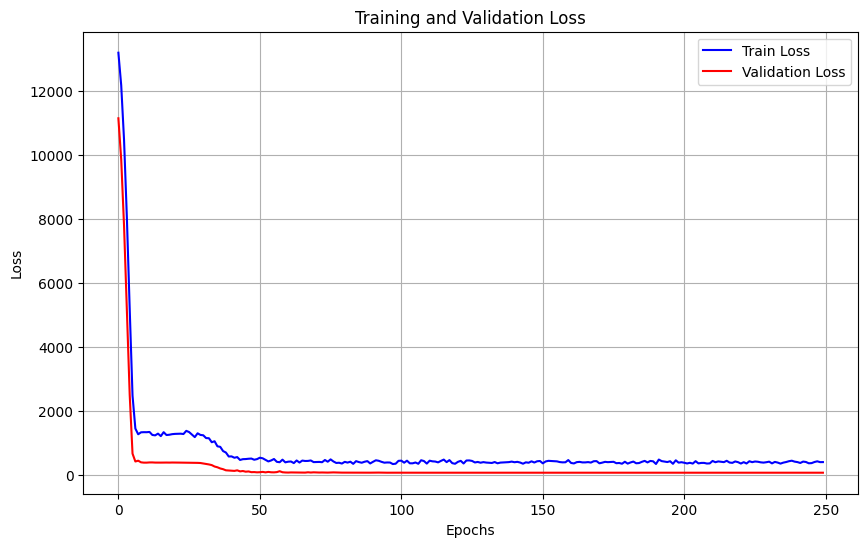

In [82]:
# Plot the loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


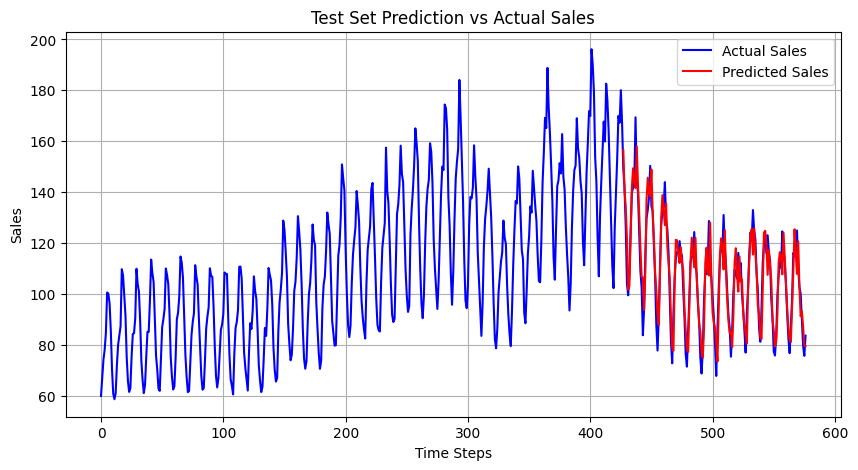

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape X_test to match the model input shape (batch_size, sequence_length, 1)
X_test_reshaped = np.array(X_test).reshape(-1, sequence_length, 1)

# Make predictions on the test set
y_pred = model_LSTM.predict(X_test_reshaped)

# Convert predictions to a 1D array
y_pred = y_pred.flatten()

# Define time steps for the test set
time_steps_test = np.arange(split_index + sequence_length, len(vals))

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(vals, label="Actual Sales", color='blue')
plt.plot(time_steps_test, y_pred, label="Predicted Sales", color='red')
plt.legend()
plt.grid(True)
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.title("Test Set Prediction vs Actual Sales")
plt.show()

    1.4 Implementing a GRU Model

In [84]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Reshape to 2D (samples, features) before scaling
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Fit and transform
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to 3D for LSTM (samples, time_steps, features) (In general)
# In this case, we only have 1 feature. Hence, (samples, time_steps, 1) is equivalent to (samples, time_steps)
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

print(X_train.shape)  
print(y_train.shape)  

(403, 24)
(403,)


In [85]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers

model_GRU = Sequential([
    GRU(units=50, input_shape=(sequence_length, 1)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Reduce learning rate on plateau callback
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

# Compile the model
model_GRU.compile(optimizer=Adam(learning_rate=0.002), loss='mse')

# Display the model summary
model_GRU.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 50)                  │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 32)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,615 (37.56 KB)

 Trainable params: 9,615 (37.56 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
history = model_GRU.fit(X_train_reshaped, y_train, 
                    validation_data=(X_test_reshaped, y_test), 
                    epochs=250, 
                    callbacks=[reduceLR])

Epoch 1/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 13527.6260 - val_loss: 11526.5293 - learning_rate: 0.0020
Epoch 2/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12747.1992 - val_loss: 11085.3623 - learning_rate: 0.0020
Epoch 3/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12643.5420 - val_loss: 10373.9170 - learning_rate: 0.0020
Epoch 4/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11994.0156 - val_loss: 9491.9199 - learning_rate: 0.0020
Epoch 5/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10713.6377 - val_loss: 8461.4004 - learning_rate: 0.0020
Epoch 6/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9317.1562 - val_loss: 7215.1401 - learning_rate: 0.0020
Epoch 7/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8238.7549 - val_loss: 5706.3975 - learning_rate: 0.0020
Epoch 8/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6636.6807 - val_loss: 4243.1440 - learning_rate: 0.0020
Epoch 9/250
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4621.6011 - 

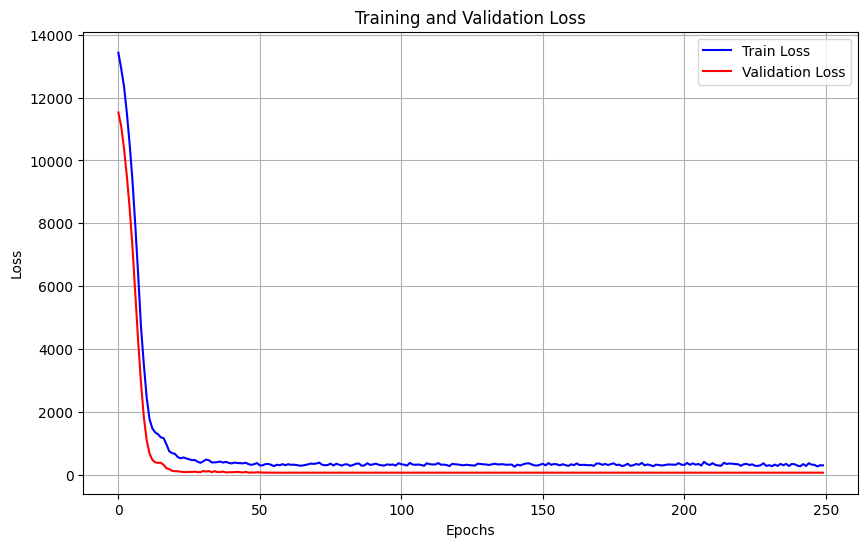

In [87]:
# Plot the loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


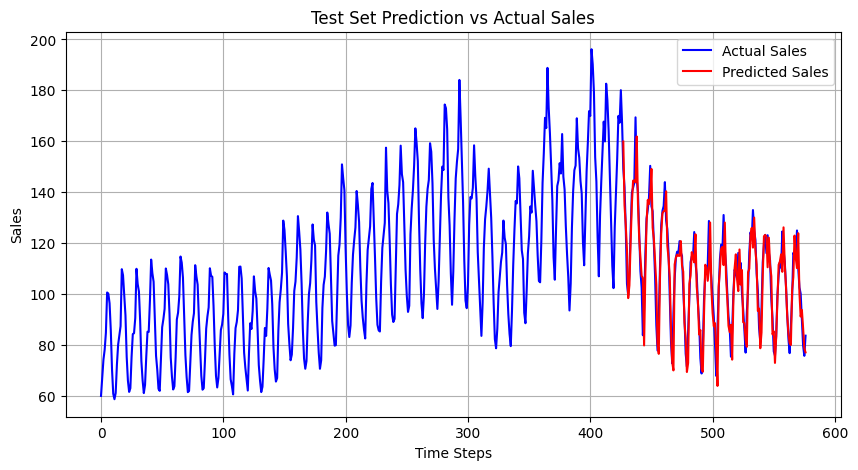

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape X_test to match the model input shape (batch_size, sequence_length, 1)
X_test_reshaped = np.array(X_test).reshape(-1, sequence_length, 1)

# Make predictions on the test set
y_pred = model_GRU.predict(X_test_reshaped)

# Convert predictions to a 1D array
y_pred = y_pred.flatten()

# Define time steps for the test set
time_steps_test = np.arange(split_index + sequence_length, len(vals))

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(vals, label="Actual Sales", color='blue')
plt.plot(time_steps_test, y_pred, label="Predicted Sales", color='red')
plt.legend()
plt.grid(True)
plt.xlabel("Time Steps")
plt.ylabel("Sales")
plt.title("Test Set Prediction vs Actual Sales")
plt.show()